### Behavior of charged particles on NPF days

#### Look at the summer period(known for NPF events...), June 1 - Aug 31 

In [1]:
from nais.utils import remove_bad_data
import xarray as xr

ds = xr.open_dataset("nais1_dataset.nc")
bad_data = xr.open_dataset("bad_data_bounds.nc")
ds = remove_bad_data(ds, bad_data)

In [2]:
summer_ds = ds.sel(time=slice('2024-06-01', '2024-08-31'))

In [3]:
neg_ions = summer_ds.neg_ions
pos_ions = summer_ds.pos_ions

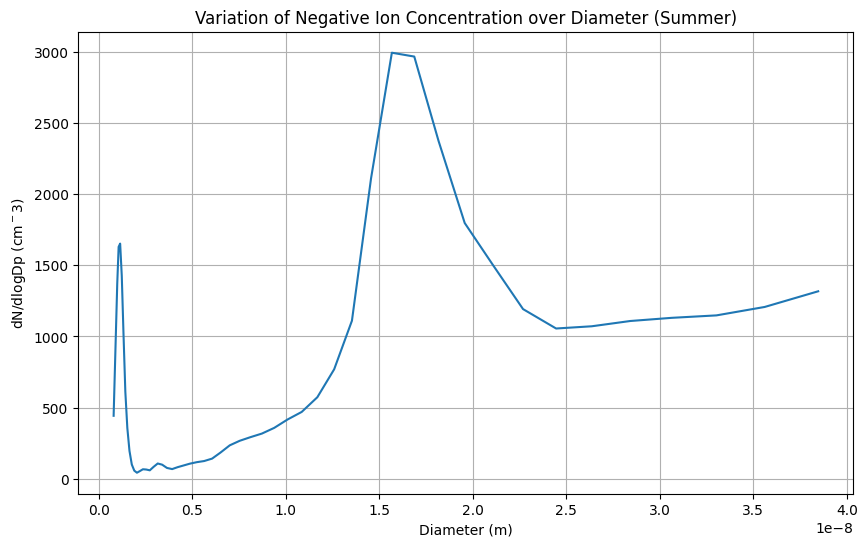

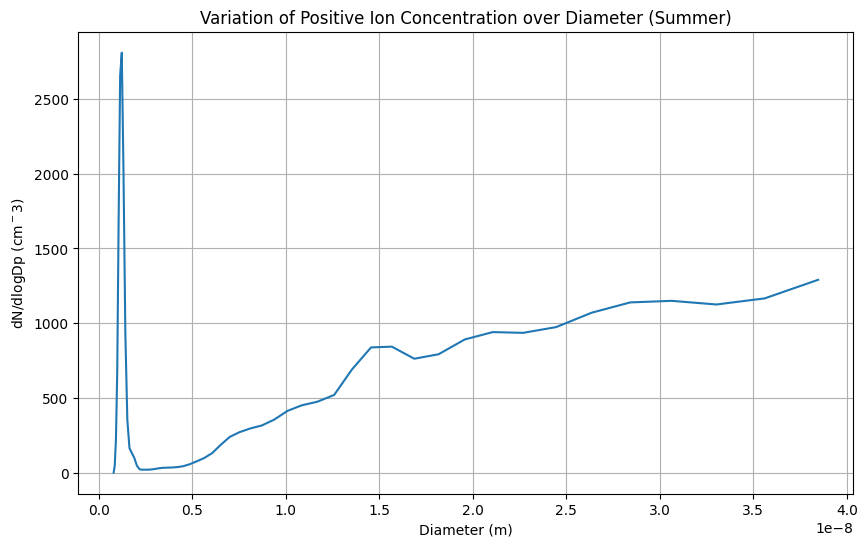

In [5]:
import matplotlib.pyplot as plt

# Plot for negative ions
plt.figure(figsize=(10, 6))
neg_ions.mean(dim='time').plot()
plt.title('Variation of Negative Ion Concentration over Diameter (Summer)')
plt.xlabel('Diameter (m)')
plt.ylabel('dN/dlogDp (cm$^-3$)')
plt.grid(True)
plt.show()

# Plot for positive ions
plt.figure(figsize=(10, 6))
pos_ions.mean(dim='time').plot()
plt.title('Variation of Positive Ion Concentration over Diameter (Summer)')
plt.xlabel('Diameter (m)')
plt.ylabel('dN/dlogDp (cm$^-3$)')
plt.grid(True)
plt.show()

In [6]:
# Divide the data into the small, large, and intermediate particles
small_neg_ions = neg_ions.sel(diameter=slice(0.8e-9,1.6e-9))
small_pos_ions = pos_ions.sel(diameter=slice(0.8e-9,1.6e-9))
intermediate_neg_ions = neg_ions.sel(diameter=slice(1.6e-9,7.5e-9))
intermediate_pos_ions = pos_ions.sel(diameter=slice(1.6e-9,7.5e-9))
large_neg_ions = neg_ions.sel(diameter=slice(7.5e-9,22e-9))
large_pos_ions = pos_ions.sel(diameter=slice(7.5e-9,22e-9))   

In [7]:
import numpy as np

In [31]:
#Convert to dataframes

small_neg_ions_df = small_neg_ions.to_dataframe(name='particles').reset_index()
small_neg_ions_df = small_neg_ions_df.pivot(index='time', columns='diameter', values='particles')
small_neg_ions_df = small_neg_ions_df.mask(small_neg_ions_df < 0, np.nan)  # Replace negative values with NaN

small_pos_ions_df = small_pos_ions.to_dataframe(name='particles').reset_index()
small_pos_ions_df = small_pos_ions_df.pivot(index='time', columns='diameter', values='particles')
small_pos_ions_df = small_pos_ions_df.mask(small_pos_ions_df < 0, np.nan)  # Replace negative values with NaN

intermediate_neg_ions_df = intermediate_neg_ions.to_dataframe(name='particles').reset_index()
intermediate_neg_ions_df = intermediate_neg_ions_df.pivot(index='time', columns='diameter', values='particles')
intermediate_neg_ions_df = intermediate_neg_ions_df.mask(intermediate_neg_ions_df < 0, np.nan)  # Replace negative values with NaN

intermediate_pos_ions_df = intermediate_pos_ions.to_dataframe(name='particles').reset_index()
intermediate_pos_ions_df = intermediate_pos_ions_df.pivot(index='time', columns='diameter', values='particles')
intermediate_pos_ions_df = intermediate_pos_ions_df.mask(intermediate_pos_ions_df < 0, np.nan)  # Replace negative values with NaN

large_neg_ions_df = large_neg_ions.to_dataframe(name='particles').reset_index()
large_neg_ions_df = large_neg_ions_df.pivot(index='time', columns='diameter', values='particles')
large_neg_ions_df = large_neg_ions_df.mask(large_neg_ions_df < 0, np.nan)  # Replace negative values with NaN

large_pos_ions_df = large_pos_ions.to_dataframe(name='particles').reset_index()
large_pos_ions_df = large_pos_ions_df.pivot(index='time', columns='diameter', values='particles')
large_pos_ions_df = large_pos_ions_df.mask(large_pos_ions_df < 0, np.nan)  # Replace negative values with NaN

In [9]:
import aerosol.functions as af

In [10]:
#Calculate particle number concentration from aerosol number-size distribution using integration and linear approximation
import pandas as pd
#import numpy as np

def calc_bin_edges(dp):
    """
    Calculate bin edges given bin centers
    
    Parameters
    ----------
    
    dp : pandas series of lenght n
        bin center diameters

    Returns
    -------

    pandas series of lenght n+1
        log bin edges

    """
    dp_arr = dp.values
    logdp_mid = np.log10(dp_arr)
    logdp = (logdp_mid[:-1]+logdp_mid[1:])/2.0
    maxval = [logdp_mid.max()+(logdp_mid.max()-logdp.max())]
    minval = [logdp_mid.min()-(logdp.min()-logdp_mid.min())]
    logdp = np.concatenate((minval,logdp,maxval))
    
    return pd.Series(logdp)

def calc_conc_interp(df,dmin,dmax):
    """
    Calculate particle number concentration from aerosol
    number-size distribution by interpolating between bins 

    Parameters
    ----------

    df : dataframe
        Aerosol number-size distribution
    dmin : float or series of length n
        Size range lower diameter(s), unit: m
    dmax : float or series of length n
        Size range upper diameter(s), unit: m

    Returns
    -------

    dataframe
        Number concentration in the given size range(s), unit: cm-3

    """

    dmin = pd.Series(dmin)
    dmax = pd.Series(dmax)

    dp = df.columns.values.astype(float)

    # Create dense diameter grid
    dp_grid = np.logspace(np.log10(dp).min(),np.log10(dp).max(),1000)

    # Interpolate to dense diameter grid
    df_interp = df.reindex(
        dp_grid,
        axis=1,
        method="nearest",
        tolerance=dp_grid[1]-dp_grid[0]).interpolate(
            axis=1,
            limit_area="inside",
            method="linear").dropna(
                axis=1,
                how="all")

    # Update the diameter grid
    dp_grid = df_interp.columns.values.astype(float)

    # Calculate bin widths in log scale 
    dlogdp_grid = np.diff(calc_bin_edges(pd.Series(dp_grid)))

    # Transform dN/dlogDp -> dN
    dn_interp = df_interp * dlogdp_grid

    conc_df = pd.DataFrame(index = df.index, columns = np.arange(len(dmin)))

    for i in range(len(dmin)):
        dp1 = np.max([dp_grid.min(), dmin.values[i]])
        dp2 = np.min([dp_grid.max(), dmax.values[i]])
        findex = np.argwhere((dp_grid<dp2)&(dp_grid>=dp1)).flatten()
        conc = dn_interp.iloc[:,findex].sum(axis=1,min_count=1)
        conc_df.iloc[:,i] = conc

    return conc_df

In [32]:
N_small_neg = calc_conc_interp(small_neg_ions_df, 0.8e-9, 1.6e-9)
N_small_neg.rename(columns={0: 'concentration'}, inplace=True)

N_small_pos = calc_conc_interp(small_pos_ions_df, 0.8e-9, 1.6e-9)
N_small_pos.rename(columns={0: 'concentration'}, inplace=True)

N_intermediate_neg = calc_conc_interp(intermediate_neg_ions_df, 1.6e-9, 7.5e-9)
N_intermediate_neg.rename(columns={0: 'concentration'}, inplace=True)

N_intermediate_pos = calc_conc_interp(intermediate_pos_ions_df, 1.6e-9, 7.5e-9)
N_intermediate_pos.rename(columns={0: 'concentration'}, inplace=True)

N_large_neg = calc_conc_interp(large_neg_ions_df, 7.5e-9, 22e-9)
N_large_neg.rename(columns={0: 'concentration'}, inplace=True)

N_large_pos = calc_conc_interp(large_pos_ions_df, 7.5e-9, 22e-9)
N_large_pos.rename(columns={0: 'concentration'}, inplace=True)

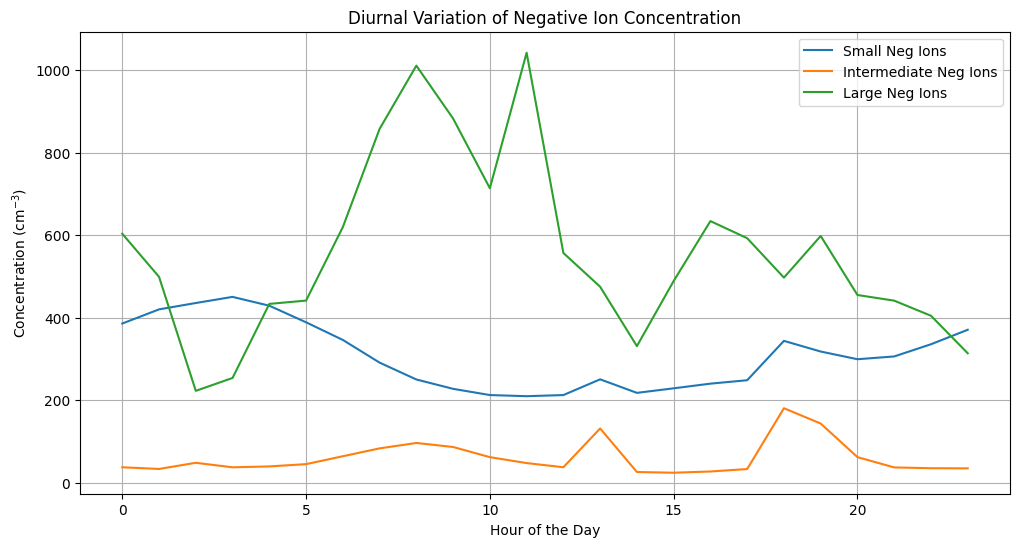

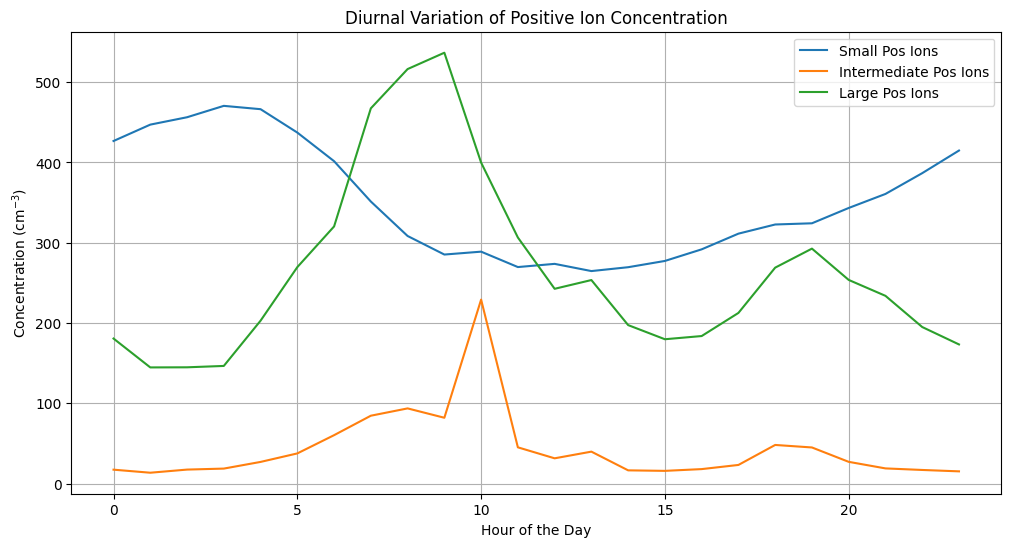

In [12]:
# Group by hour and calculate the mean concentration for each hour
N_small_neg_hourly = N_small_neg.groupby(N_small_neg.index.hour).mean()
N_intermediate_neg_hourly = N_intermediate_neg.groupby(N_intermediate_neg.index.hour).mean()
N_large_neg_hourly = N_large_neg.groupby(N_large_neg.index.hour).mean()

N_small_pos_hourly = N_small_pos.groupby(N_small_pos.index.hour).mean()
N_intermediate_pos_hourly = N_intermediate_pos.groupby(N_intermediate_pos.index.hour).mean()
N_large_pos_hourly = N_large_pos.groupby(N_large_pos.index.hour).mean()

# Plot for negative ions
plt.figure(figsize=(12, 6))
plt.plot(N_small_neg_hourly.index, N_small_neg_hourly['concentration'], label='Small Neg Ions')
plt.plot(N_intermediate_neg_hourly.index, N_intermediate_neg_hourly['concentration'], label='Intermediate Neg Ions')
plt.plot(N_large_neg_hourly.index, N_large_neg_hourly['concentration'], label='Large Neg Ions')
plt.title('Diurnal Variation of Negative Ion Concentration')
plt.xlabel('Hour of the Day')
plt.ylabel('Concentration (cm$^{-3}$)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for positive ions
plt.figure(figsize=(12, 6))
plt.plot(N_small_pos_hourly.index, N_small_pos_hourly['concentration'], label='Small Pos Ions')
plt.plot(N_intermediate_pos_hourly.index, N_intermediate_pos_hourly['concentration'], label='Intermediate Pos Ions')
plt.plot(N_large_pos_hourly.index, N_large_pos_hourly['concentration'], label='Large Pos Ions')
plt.title('Diurnal Variation of Positive Ion Concentration')
plt.xlabel('Hour of the Day')
plt.ylabel('Concentration (cm$^{-3}$)')
plt.legend()
plt.grid(True)
plt.show()

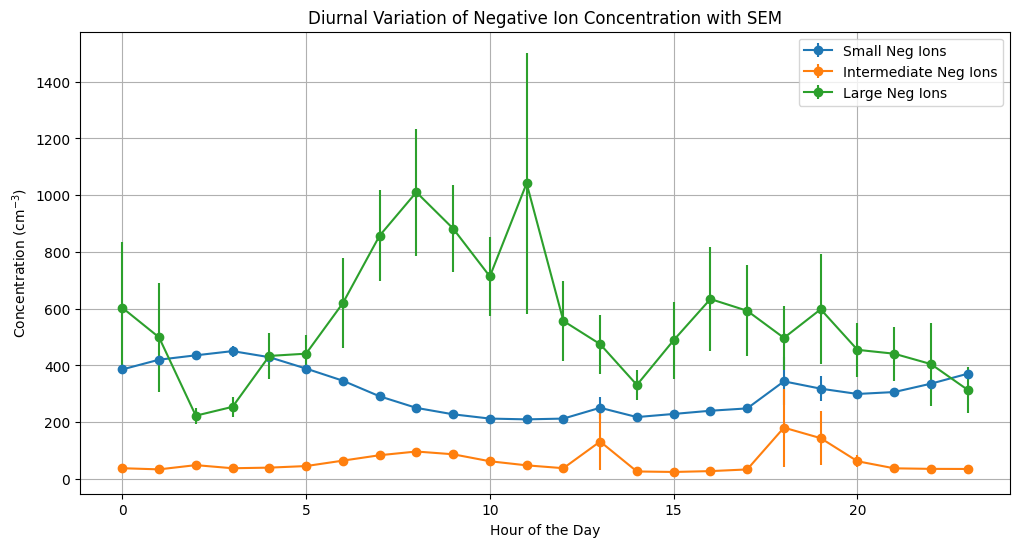

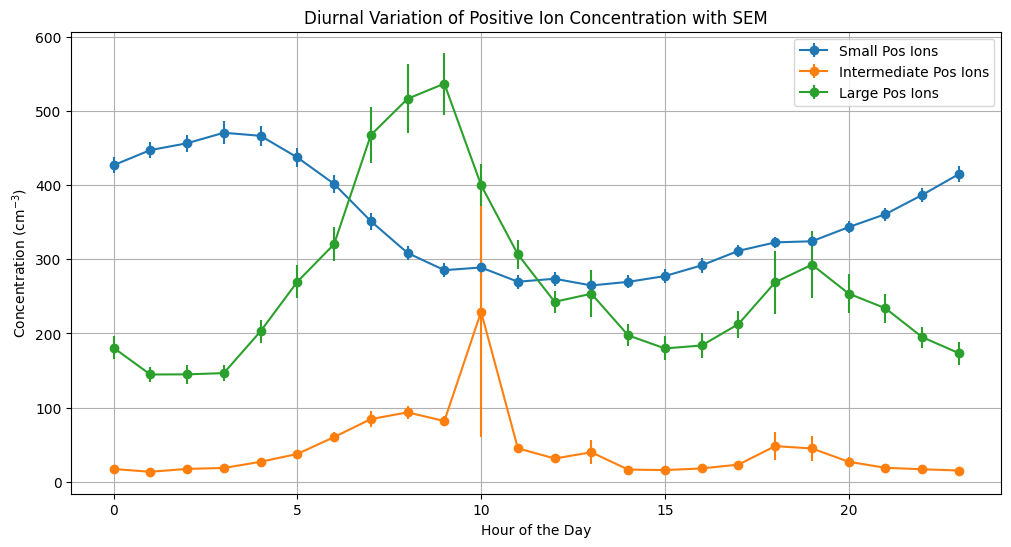

In [ ]:
# Calculate the standard error of the mean (SEM)
N_small_neg_hourly_sem = N_small_neg.groupby(N_small_neg.index.hour).sem()
N_intermediate_neg_hourly_sem = N_intermediate_neg.groupby(N_intermediate_neg.index.hour).sem()
N_large_neg_hourly_sem = N_large_neg.groupby(N_large_neg.index.hour).sem()

N_small_pos_hourly_sem = N_small_pos.groupby(N_small_pos.index.hour).sem()
N_intermediate_pos_hourly_sem = N_intermediate_pos.groupby(N_intermediate_pos.index.hour).sem()
N_large_pos_hourly_sem = N_large_pos.groupby(N_large_pos.index.hour).sem()

# Plot for negative ions with SEM
plt.figure(figsize=(12, 6))
plt.errorbar(N_small_neg_hourly.index, N_small_neg_hourly['concentration'], yerr=N_small_neg_hourly_sem['concentration'], label='Small Neg Ions', fmt='-o')
plt.errorbar(N_intermediate_neg_hourly.index, N_intermediate_neg_hourly['concentration'], yerr=N_intermediate_neg_hourly_sem['concentration'], label='Intermediate Neg Ions', fmt='-o')
plt.errorbar(N_large_neg_hourly.index, N_large_neg_hourly['concentration'], yerr=N_large_neg_hourly_sem['concentration'], label='Large Neg Ions', fmt='-o')
plt.title('Diurnal Variation of Negative Ion Concentration with SEM')
plt.xlabel('Hour of the Day')
plt.ylabel('Number Concentration (cm$^{-3}$)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for positive ions with SEM
plt.figure(figsize=(12, 6))
plt.errorbar(N_small_pos_hourly.index, N_small_pos_hourly['concentration'], yerr=N_small_pos_hourly_sem['concentration'], label='Small Pos Ions', fmt='-o')
plt.errorbar(N_intermediate_pos_hourly.index, N_intermediate_pos_hourly['concentration'], yerr=N_intermediate_pos_hourly_sem['concentration'], label='Intermediate Pos Ions', fmt='-o')
plt.errorbar(N_large_pos_hourly.index, N_large_pos_hourly['concentration'], yerr=N_large_pos_hourly_sem['concentration'], label='Large Pos Ions', fmt='-o')
plt.title('Diurnal Variation of Positive Ion Concentration with SEM')
plt.xlabel('Hour of the Day')
plt.ylabel('Number Concentration (cm$^{-3}$)')
plt.legend()
plt.grid(True)
plt.show()

### Identify the NPF days

In [ ]:
import os

# Create a directory to save the plots
output_dir = 'daily_plots'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each day in the dataset
for day in pd.date_range(start='2024-06-01', end='2024-08-31'):
    day_str = day.strftime('%Y-%m-%d')
    
    # Select data for the specific day
    neg_ions_day = neg_ions.sel(time=day_str)
    pos_ions_day = pos_ions.sel(time=day_str)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot contour for negative ions
    c1 = axs[0].contourf(neg_ions_day.time, neg_ions_day.diameter, neg_ions_day.T, levels=100, cmap='YlGnBu')
    axs[0].set_title(f'Negative Ion Concentration on {day_str}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Diameter (m)')
    axs[0].set_yscale('log')
    axs[0].grid(True)
    fig.colorbar(c1, ax=axs[0], label='Concentration (cm$^{-3}$)')
    
    # Plot contour for positive ions
    c2 = axs[1].contourf(pos_ions_day.time, pos_ions_day.diameter, pos_ions_day.T, levels=100, cmap='YlGnBu')
    axs[1].set_title(f'Positive Ion Concentration on {day_str}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Diameter (m)')
    axs[1].set_yscale('log')
    axs[1].grid(True)
    fig.colorbar(c2, ax=axs[1], label='Concentration (cm$^{-3}$)')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'ions_{day_str}.png'))
    plt.close()

In [20]:
npf_days = ('2024-06-01', '2024-06-04', '2024-06-05', '2024-06-10', '2024-06-14', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-20', '2024-06-24', '2024-06-25', '2024-06-28', '2024-07-02', '2024-07-04', '2024-07-11', '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-28', '2024-07-29', '2024-07-31', '2024-08-02', '2024-08-04', '2024-08-05', '2024-08-06', '2024-08-10', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-19', '2024-08-24', '2024-08-25', '2024-08-30')
undefined_days = ('2024-06-06', '2024-06-07', '2024-06-08', '2024-06-11', '2024-06-15', '2024-07-01', '2024-07-05', '2024-07-07', '2024-07-10', '2024-07-12', '2024-07-13', '2024-07-18', '2024-07-23', '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-30', '2024-08-01', '2024-08-08', '2024-08-17', '2024-08-22', '2024-08-23')
nonevent_days = ('2024-06-02', '2024-06-03', '2024-06-09', '2024-06-12', '2024-06-13', '2024-06-19', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-26', '2024-06-27', '2024-06-29', '2024-06-30', '2024-07-03', '2024-07-06', '2024-07-08', '2024-07-09', '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-24', '2024-08-03', '2024-08-07', '2024-08-09', '2024-08-11', '2024-08-12', '2024-08-13', '2024-08-18', '2024-08-20', '2024-08-21', '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-31')

In [33]:
# Rename the concentration columns
N_small_neg.rename(columns={'concentration': 'N_small_neg concentration'}, inplace=True)
N_small_pos.rename(columns={'concentration': 'N_small_pos concentration'}, inplace=True)
N_intermediate_neg.rename(columns={'concentration': 'N_intermediate_neg concentration'}, inplace=True)
N_intermediate_pos.rename(columns={'concentration': 'N_intermediate_pos concentration'}, inplace=True)
N_large_neg.rename(columns={'concentration': 'N_large_neg concentration'}, inplace=True)
N_large_pos.rename(columns={'concentration': 'N_large_pos concentration'}, inplace=True)

# Merge dataframes based on the time index
merged_df = pd.concat([N_small_neg, N_small_pos, N_intermediate_neg, N_intermediate_pos, N_large_neg, N_large_pos], axis=1)

# Display the merged dataframe
merged_df

,N_small_neg concentration,N_small_pos concentration,N_intermediate_neg concentration,N_intermediate_pos concentration,N_large_neg concentration,N_large_pos concentration
time,,,,,,
2024-06-01 00:00:00,364.473293,573.975236,100.161019,35.457905,125.087292,174.042447
2024-06-01 01:00:00,430.174295,542.514267,80.852694,31.324339,180.469846,163.4871
2024-06-01 02:00:00,318.199048,504.616192,72.116971,30.233318,310.717591,279.942757
2024-06-01 03:00:00,371.788141,475.235822,52.75149,19.521112,176.048365,119.530784
2024-06-01 04:00:00,355.639927,450.201064,27.05646,15.542155,133.634676,101.343069
...,...,...,...,...,...,...
2024-08-31 19:00:00,149.94655,274.262653,34.067245,16.614354,173.80411,202.038819
2024-08-31 20:00:00,160.495036,289.811928,30.564345,19.580327,164.232531,207.967946
2024-08-31 21:00:00,244.821035,369.178583,21.370701,11.782197,164.341355,223.888463


In [34]:
met_data = pd.read_csv('/home/coliewo/Documents/Data Analysis/NPF/Data/Met/met_jan_dec.csv')
met_data['datetime'] = pd.to_datetime(met_data['date'] + ' ' + met_data['time'])
met_data.drop(['date', 'time'], axis=1, inplace=True)  # drop date and time columns
met_data.index = met_data['datetime']
met_data = met_data.resample('1h').mean()

In [35]:
# Select the columns to merge from met_data
met_columns = ['RH[%%]', 'T_air[C]', 'WS_ave[m/s]', 'P_air[hPa]']

# Merge the selected columns from met_data into merged_df based on the timestep
merged_df = merged_df.merge(met_data[met_columns], left_index=True, right_index=True, how='left')

# Display the updated merged dataframe
merged_df

,N_small_neg concentration,N_small_pos concentration,N_intermediate_neg concentration,N_intermediate_pos concentration,N_large_neg concentration,N_large_pos concentration,RH[%%],T_air[C],WS_ave[m/s],P_air[hPa]
time,,,,,,,,,,
2024-06-01 00:00:00,364.473293,573.975236,100.161019,35.457905,125.087292,174.042447,53.471667,15.235000,2.551667,1001.148333
2024-06-01 01:00:00,430.174295,542.514267,80.852694,31.324339,180.469846,163.4871,54.060000,14.948333,2.133333,1001.273333
2024-06-01 02:00:00,318.199048,504.616192,72.116971,30.233318,310.717591,279.942757,59.060000,14.028333,0.800000,1001.510000
2024-06-01 03:00:00,371.788141,475.235822,52.75149,19.521112,176.048365,119.530784,55.183333,14.770000,2.248333,1001.918333
2024-06-01 04:00:00,355.639927,450.201064,27.05646,15.542155,133.634676,101.343069,51.488333,16.216667,1.958333,1002.650000
...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,149.94655,274.262653,34.067245,16.614354,173.80411,202.038819,38.088333,29.640000,1.110000,1009.176667
2024-08-31 20:00:00,160.495036,289.811928,30.564345,19.580327,164.232531,207.967946,43.821667,28.051667,0.881667,1009.321667
2024-08-31 21:00:00,244.821035,369.178583,21.370701,11.782197,164.341355,223.888463,47.931667,26.925000,0.513333,1009.476667


In [36]:
# NOx data
nox_data = pd.read_csv('/home/coliewo/Documents/Data Analysis/NPF/Data/Pollutants/nox_2024.csv')
nox_data['datetime'] = pd.to_datetime(nox_data['date'] + ' ' + nox_data['time'])
nox_data.drop(['date', 'time'], axis=1, inplace=True)  # drop date and time columns
nox_data.index = nox_data['datetime']

# Replace values with NaN where 'status' is 'SPAN'
nox_data.loc[nox_data['status'] == 'SPAN', ['NO[ppb]', 'NO2[ppb]', 'NOx[ppb]']] = np.nan

# Replace values less than 0 with NaN in specific columns (if physically impossible)
nox_data[['NO[ppb]', 'NO2[ppb]', 'NOx[ppb]']] = nox_data[['NO[ppb]', 'NO2[ppb]', 'NOx[ppb]']].map(lambda x: np.nan if x < 0 else x)

nox_data = nox_data[['NO2[ppb]','NO[ppb]','NOx[ppb]']].resample('1h').mean()

In [ ]:
# Select the columns to merge from nox_data
nox_columns = ['NO2[ppb]','NO[ppb]','NOx[ppb]']

# Merge the selected columns from nox_data into merged_df based on the timestep
merged_df = merged_df.merge(nox_data[nox_columns], left_index=True, right_index=True, how='left')

# Display the updated merged dataframe
merged_df

,N_small_neg concentration,N_small_pos concentration,N_intermediate_neg concentration,N_intermediate_pos concentration,N_large_neg concentration,N_large_pos concentration,RH[%%],T_air[C],WS_ave[m/s],P_air[hPa],NO2[ppb],NO[ppb],NOx[ppb]
time,,,,,,,,,,,,,
2024-06-01 00:00:00,364.473293,573.975236,100.161019,35.457905,125.087292,174.042447,53.471667,15.235000,2.551667,1001.148333,0.824250,NaN,0.642817
2024-06-01 01:00:00,430.174295,542.514267,80.852694,31.324339,180.469846,163.4871,54.060000,14.948333,2.133333,1001.273333,0.998600,NaN,0.914483
2024-06-01 02:00:00,318.199048,504.616192,72.116971,30.233318,310.717591,279.942757,59.060000,14.028333,0.800000,1001.510000,3.418550,0.331667,3.342700
2024-06-01 03:00:00,371.788141,475.235822,52.75149,19.521112,176.048365,119.530784,55.183333,14.770000,2.248333,1001.918333,1.662050,0.018000,1.510733
2024-06-01 04:00:00,355.639927,450.201064,27.05646,15.542155,133.634676,101.343069,51.488333,16.216667,1.958333,1002.650000,2.490033,5.344200,3.256133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,149.94655,274.262653,34.067245,16.614354,173.80411,202.038819,38.088333,29.640000,1.110000,1009.176667,8.887683,NaN,8.740983
2024-08-31 20:00:00,160.495036,289.811928,30.564345,19.580327,164.232531,207.967946,43.821667,28.051667,0.881667,1009.321667,8.997083,NaN,8.916067
2024-08-31 21:00:00,244.821035,369.178583,21.370701,11.782197,164.341355,223.888463,47.931667,26.925000,0.513333,1009.476667,10.017733,4.283125,10.487817


In [38]:
# O3 data
o3_data = pd.read_csv('/home/coliewo/Documents/Data Analysis/NPF/Data/Pollutants/ozone_2024.csv')
o3_data['datetime'] = pd.to_datetime(o3_data['date'] + ' ' + o3_data['time'])
o3_data.drop(['date', 'time'], axis=1, inplace=True)  # drop date and time columns
o3_data.index = o3_data['datetime']
# Replace values less than 0 with NaN in specific columns (if physically impossible)
o3_data[['O3']] = o3_data[['O3']].map(lambda x: np.nan if x < 0 else x)
o3_data = o3_data[['O3']].resample('1h').mean()

In [39]:
# Merge the selected columns from o3_data into merged_df based on the timestep
merged_df = merged_df.merge(o3_data, left_index=True, right_index=True, how='left')

# Display the updated merged dataframe
merged_df

,N_small_neg concentration,N_small_pos concentration,N_intermediate_neg concentration,N_intermediate_pos concentration,N_large_neg concentration,N_large_pos concentration,RH[%%],T_air[C],WS_ave[m/s],P_air[hPa],NO2[ppb],NO[ppb],NOx[ppb],O3
time,,,,,,,,,,,,,,
2024-06-01 00:00:00,364.473293,573.975236,100.161019,35.457905,125.087292,174.042447,53.471667,15.235000,2.551667,1001.148333,0.824250,NaN,0.642817,31.517667
2024-06-01 01:00:00,430.174295,542.514267,80.852694,31.324339,180.469846,163.4871,54.060000,14.948333,2.133333,1001.273333,0.998600,NaN,0.914483,31.444833
2024-06-01 02:00:00,318.199048,504.616192,72.116971,30.233318,310.717591,279.942757,59.060000,14.028333,0.800000,1001.510000,3.418550,0.331667,3.342700,25.037667
2024-06-01 03:00:00,371.788141,475.235822,52.75149,19.521112,176.048365,119.530784,55.183333,14.770000,2.248333,1001.918333,1.662050,0.018000,1.510733,32.799000
2024-06-01 04:00:00,355.639927,450.201064,27.05646,15.542155,133.634676,101.343069,51.488333,16.216667,1.958333,1002.650000,2.490033,5.344200,3.256133,34.946667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,149.94655,274.262653,34.067245,16.614354,173.80411,202.038819,38.088333,29.640000,1.110000,1009.176667,8.887683,NaN,8.740983,36.975000
2024-08-31 20:00:00,160.495036,289.811928,30.564345,19.580327,164.232531,207.967946,43.821667,28.051667,0.881667,1009.321667,8.997083,NaN,8.916067,34.424000
2024-08-31 21:00:00,244.821035,369.178583,21.370701,11.782197,164.341355,223.888463,47.931667,26.925000,0.513333,1009.476667,10.017733,4.283125,10.487817,30.053667


In [40]:
# BC data
bc_data = pd.read_csv('/home/coliewo/Documents/Data Analysis/NPF/Data/Pollutants/bc_2024.csv')
bc_data['datetime'] = pd.to_datetime(bc_data['date'] + ' ' + bc_data['time'])
bc_data.drop(['date', 'time'], axis=1, inplace=True)  # drop date and time columns
bc_data.index = bc_data['datetime']
# Replace values less than 0 with NaN in specific columns (if physically impossible)
bc_data[['BC6[ng/m3]']] = bc_data[['BC6[ng/m3]']].map(lambda x: np.nan if x < 0 else x)
bc_data = bc_data[['BC6[ng/m3]']].resample('1h').mean()

In [41]:
# Merge the selected columns from bc_data into merged_df based on the timestep
merged_df = merged_df.merge(bc_data, left_index=True, right_index=True, how='left')

# Display the updated merged dataframe
merged_df

,N_small_neg concentration,N_small_pos concentration,N_intermediate_neg concentration,N_intermediate_pos concentration,N_large_neg concentration,N_large_pos concentration,RH[%%],T_air[C],WS_ave[m/s],P_air[hPa],NO2[ppb],NO[ppb],NOx[ppb],O3,BC6[ng/m3]
time,,,,,,,,,,,,,,,
2024-06-01 00:00:00,364.473293,573.975236,100.161019,35.457905,125.087292,174.042447,53.471667,15.235000,2.551667,1001.148333,0.824250,NaN,0.642817,31.517667,136.941176
2024-06-01 01:00:00,430.174295,542.514267,80.852694,31.324339,180.469846,163.4871,54.060000,14.948333,2.133333,1001.273333,0.998600,NaN,0.914483,31.444833,135.966667
2024-06-01 02:00:00,318.199048,504.616192,72.116971,30.233318,310.717591,279.942757,59.060000,14.028333,0.800000,1001.510000,3.418550,0.331667,3.342700,25.037667,282.833333
2024-06-01 03:00:00,371.788141,475.235822,52.75149,19.521112,176.048365,119.530784,55.183333,14.770000,2.248333,1001.918333,1.662050,0.018000,1.510733,32.799000,187.050000
2024-06-01 04:00:00,355.639927,450.201064,27.05646,15.542155,133.634676,101.343069,51.488333,16.216667,1.958333,1002.650000,2.490033,5.344200,3.256133,34.946667,227.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,149.94655,274.262653,34.067245,16.614354,173.80411,202.038819,38.088333,29.640000,1.110000,1009.176667,8.887683,NaN,8.740983,36.975000,NaN
2024-08-31 20:00:00,160.495036,289.811928,30.564345,19.580327,164.232531,207.967946,43.821667,28.051667,0.881667,1009.321667,8.997083,NaN,8.916067,34.424000,NaN
2024-08-31 21:00:00,244.821035,369.178583,21.370701,11.782197,164.341355,223.888463,47.931667,26.925000,0.513333,1009.476667,10.017733,4.283125,10.487817,30.053667,NaN


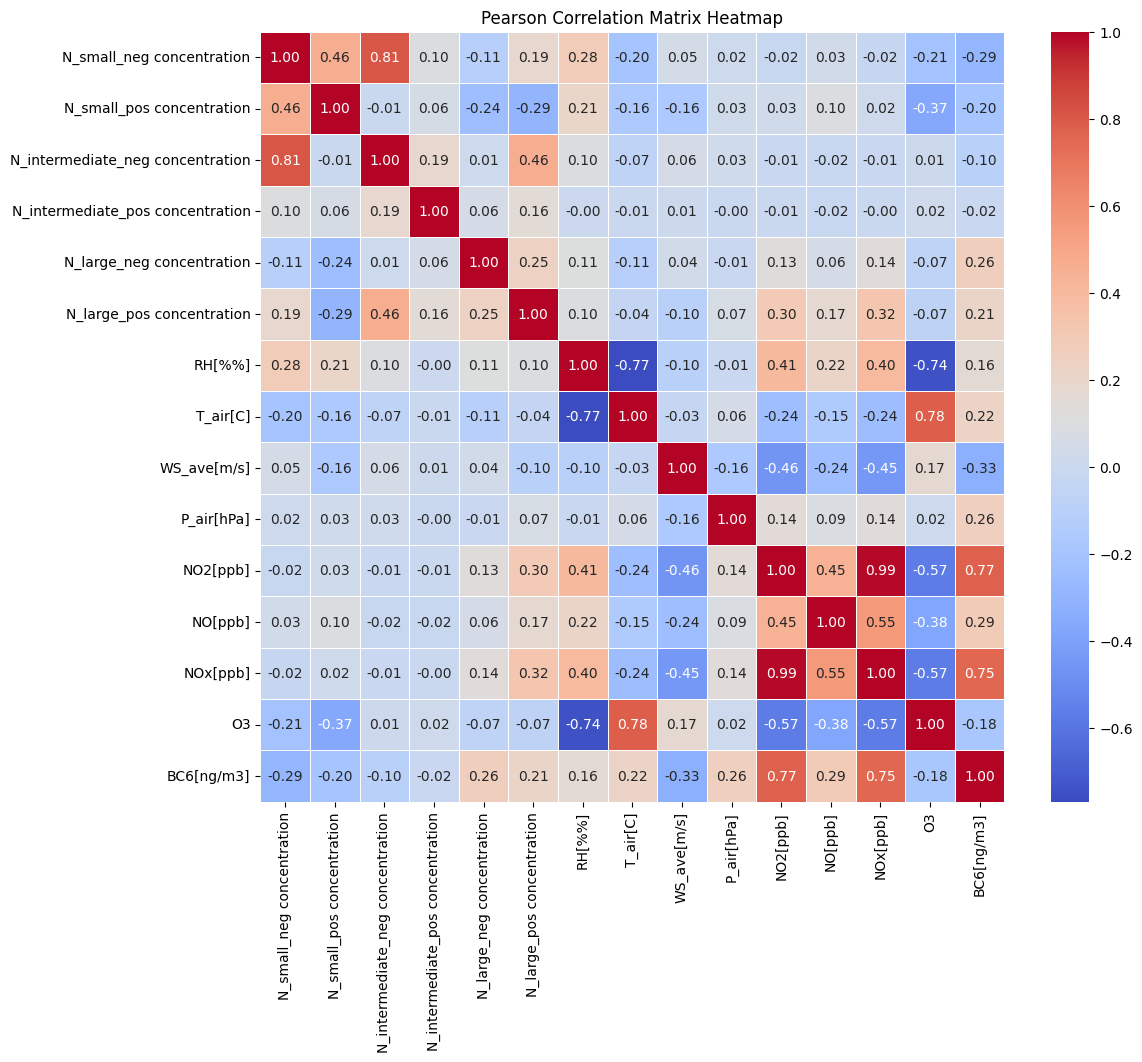

In [43]:
import seaborn as sns

# Calculate the Pearson correlation matrix
correlation_matrix = merged_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Matrix Heatmap')
plt.show()

In [45]:
# Convert the index to a datetime format if it's not already
merged_df.index = pd.to_datetime(merged_df.index)

# Divide the dataframe based on the day category
npf_df = merged_df[merged_df.index.strftime('%Y-%m-%d').isin(npf_days)]
undefined_df = merged_df[merged_df.index.strftime('%Y-%m-%d').isin(undefined_days)]
nonevent_df = merged_df[merged_df.index.strftime('%Y-%m-%d').isin(nonevent_days)]

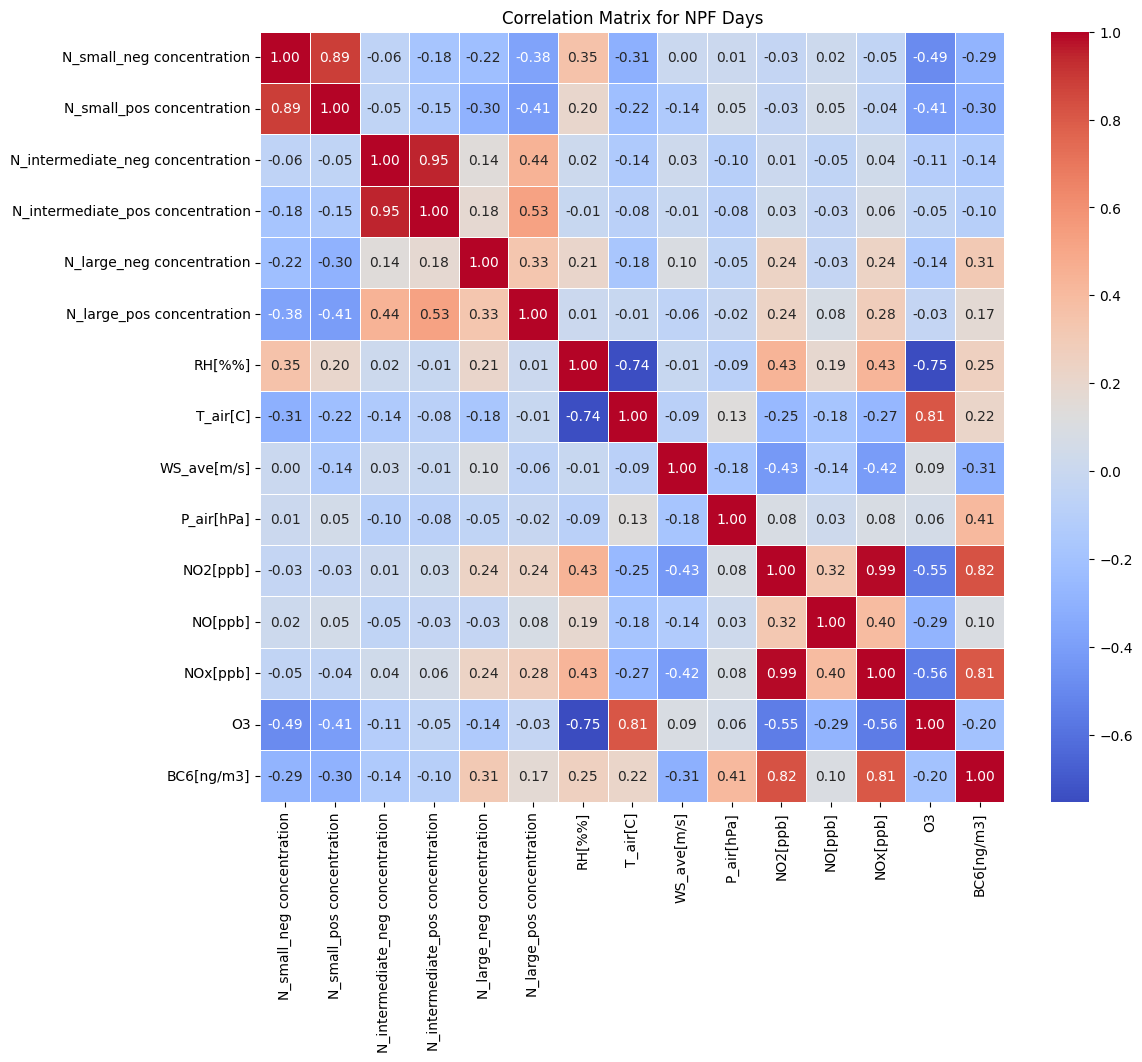

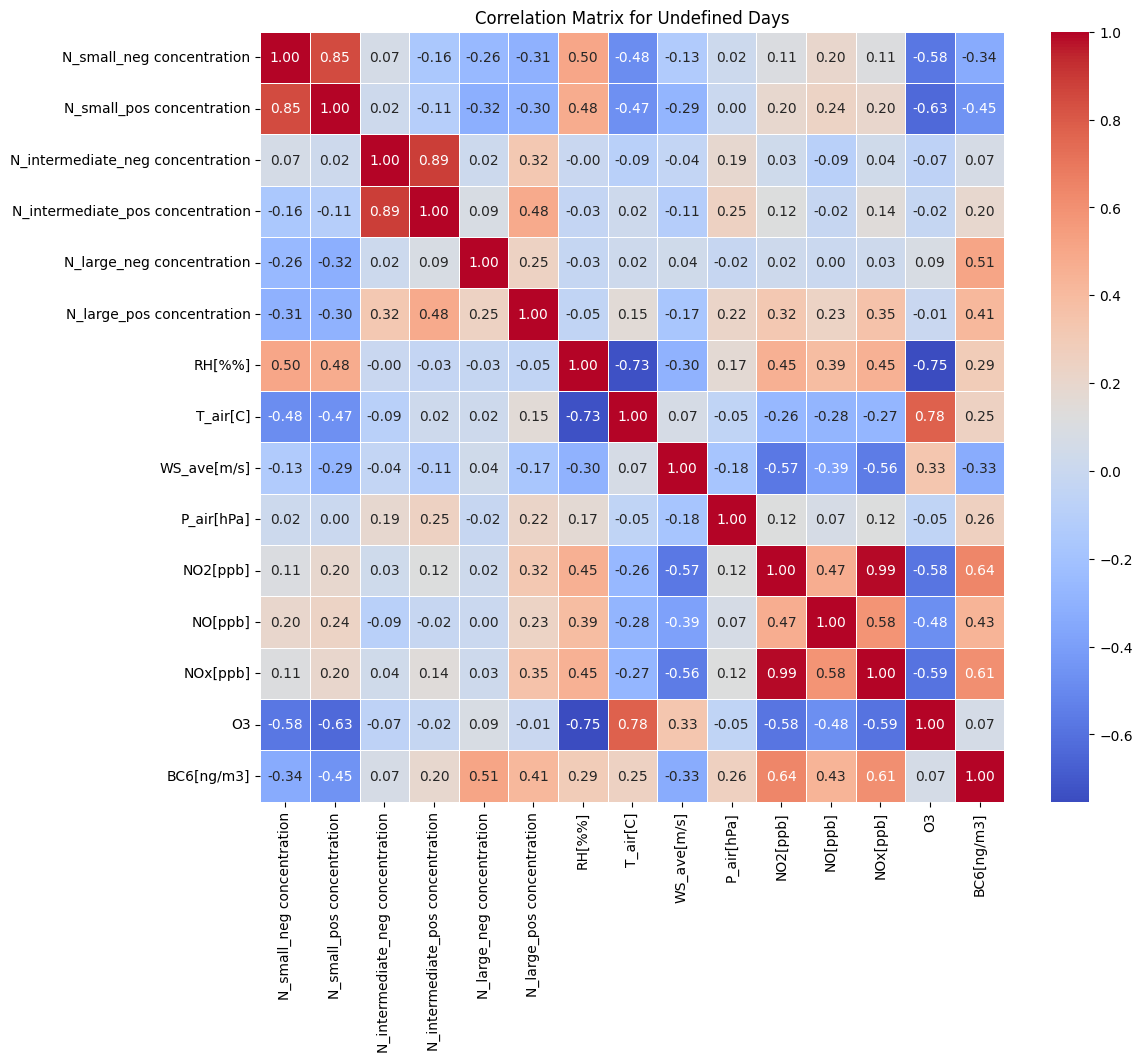

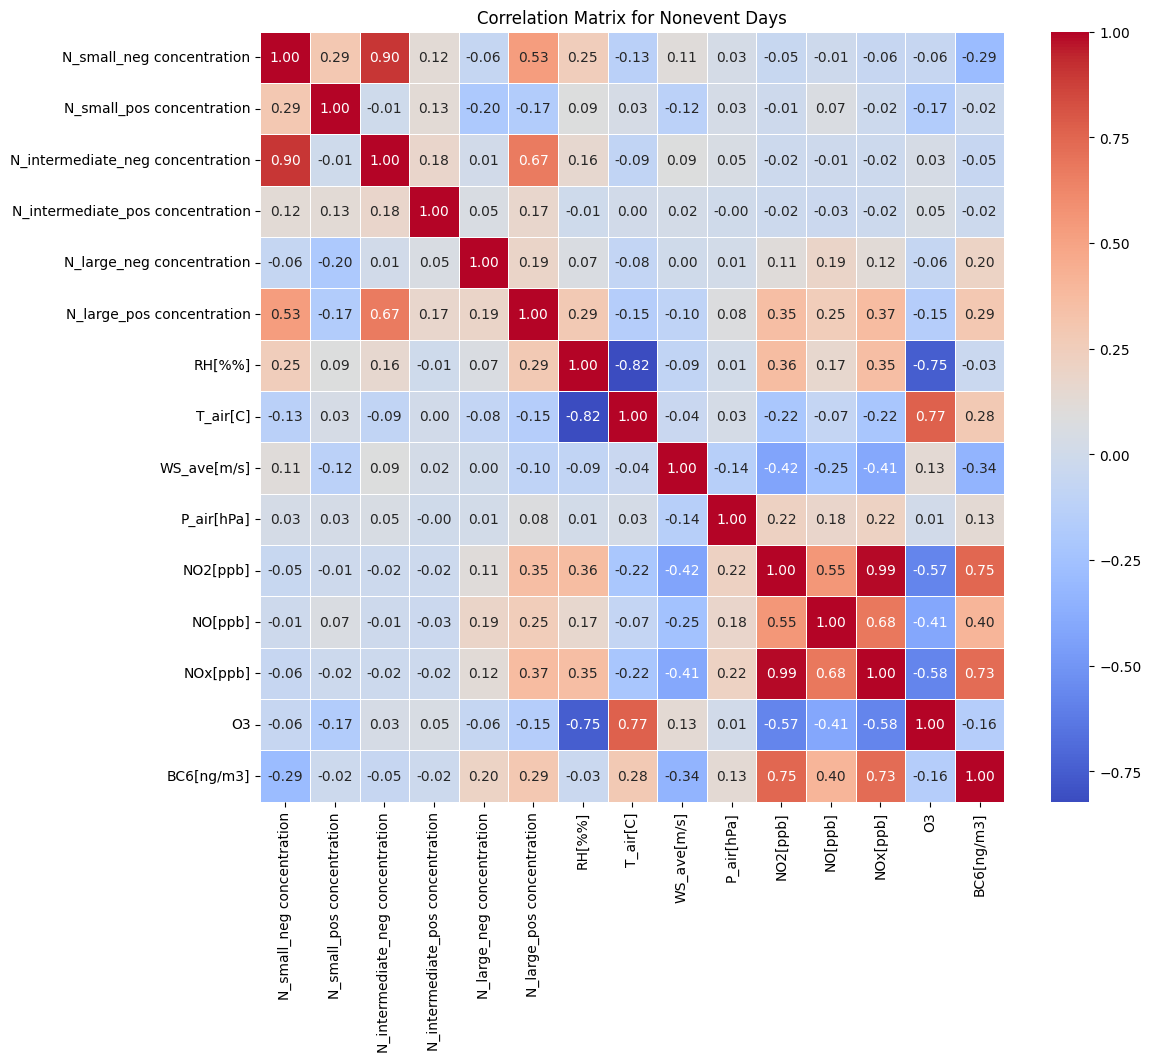

In [47]:
# Function to plot correlation matrix
def plot_correlation_matrix(df, title):
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()

# Plot correlation matrix for npf_df
plot_correlation_matrix(npf_df, 'Correlation Matrix for NPF Days')

# Plot correlation matrix for undefined_df
plot_correlation_matrix(undefined_df, 'Correlation Matrix for Undefined Days')

# Plot correlation matrix for nonevent_df
plot_correlation_matrix(nonevent_df, 'Correlation Matrix for Nonevent Days')

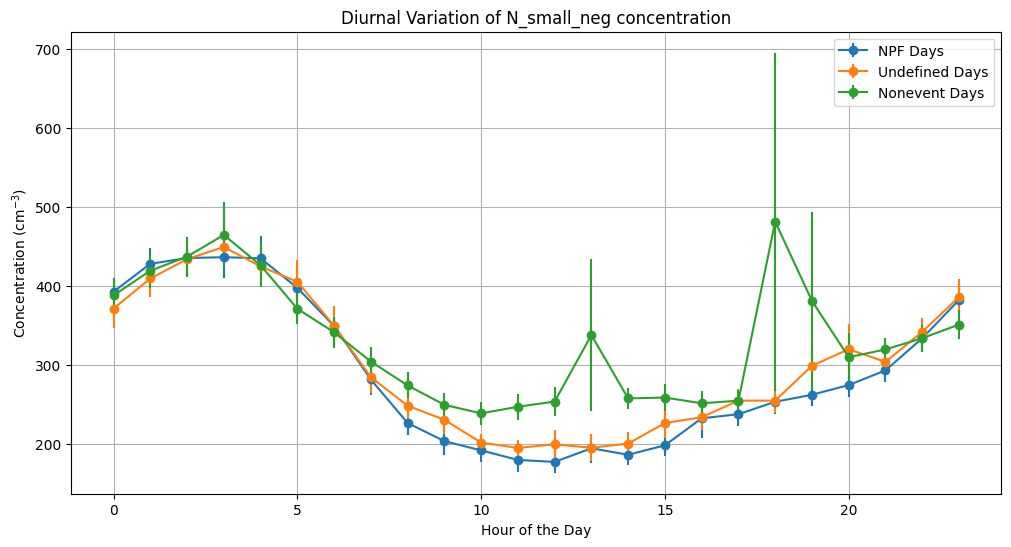

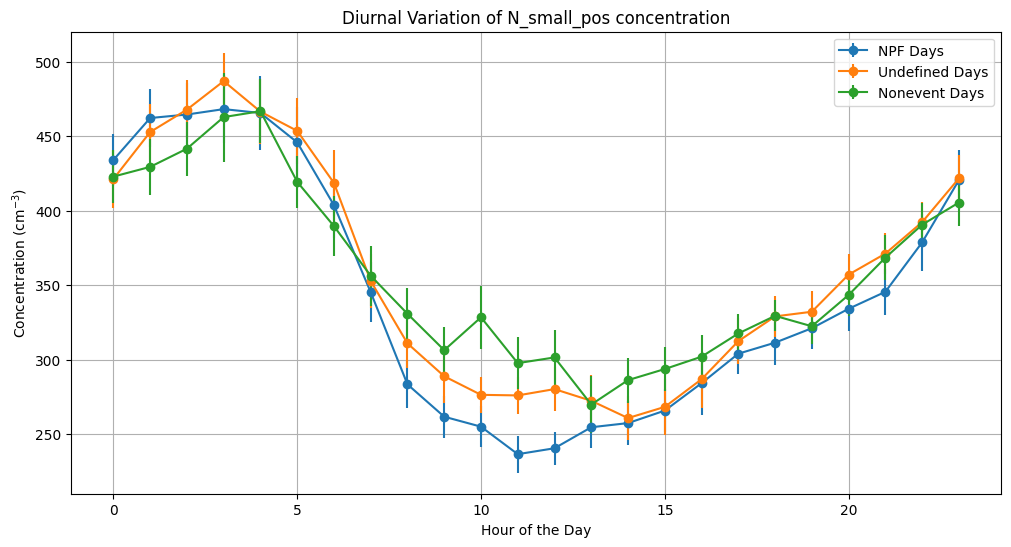

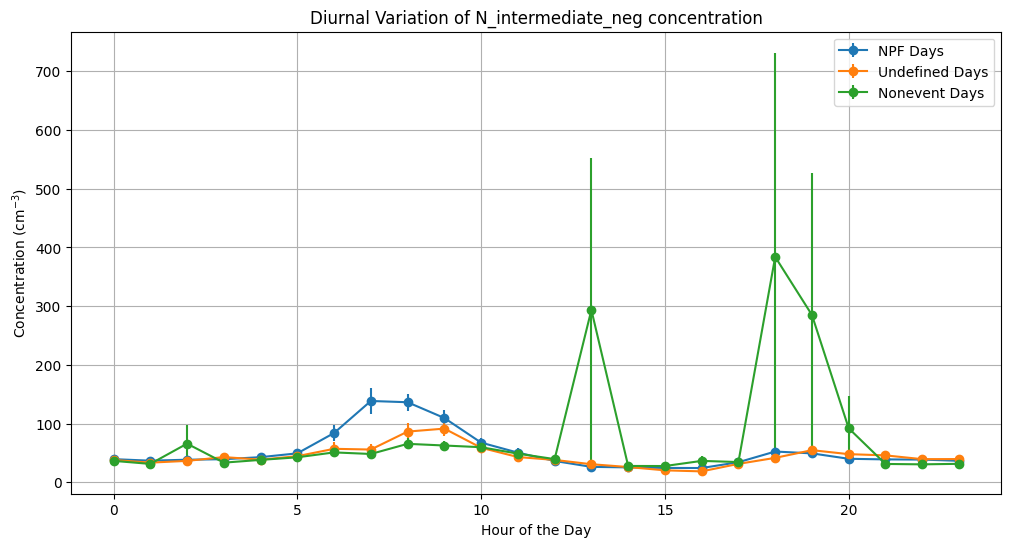

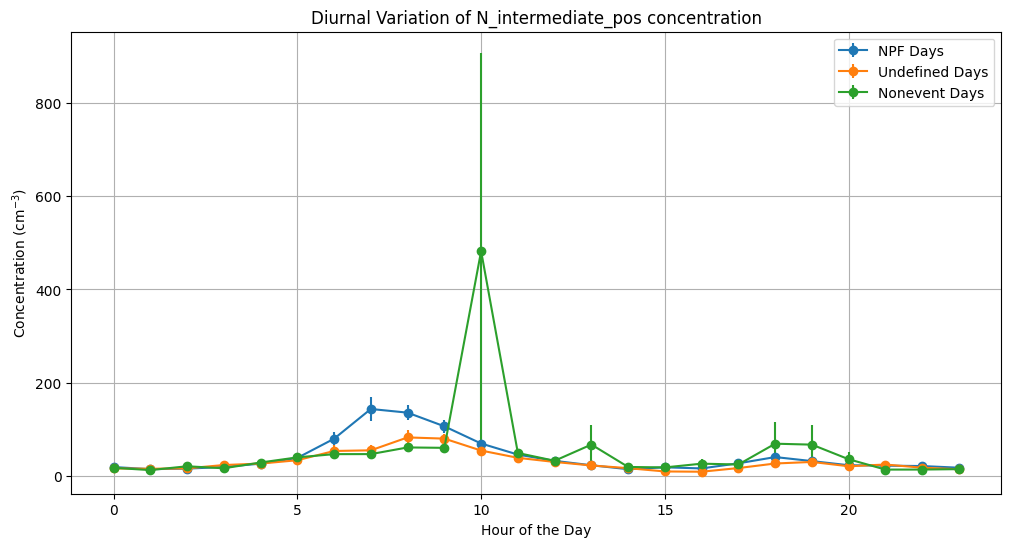

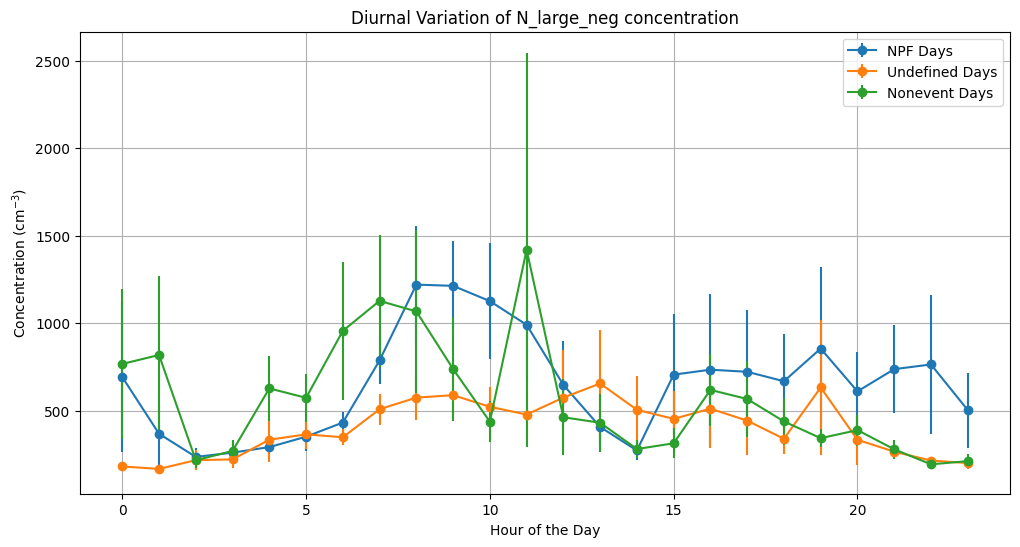

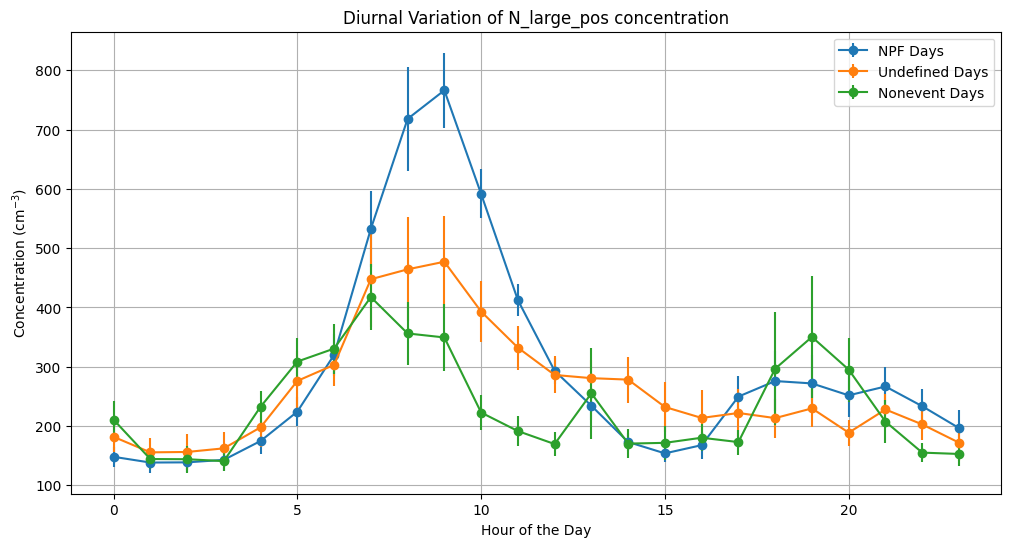

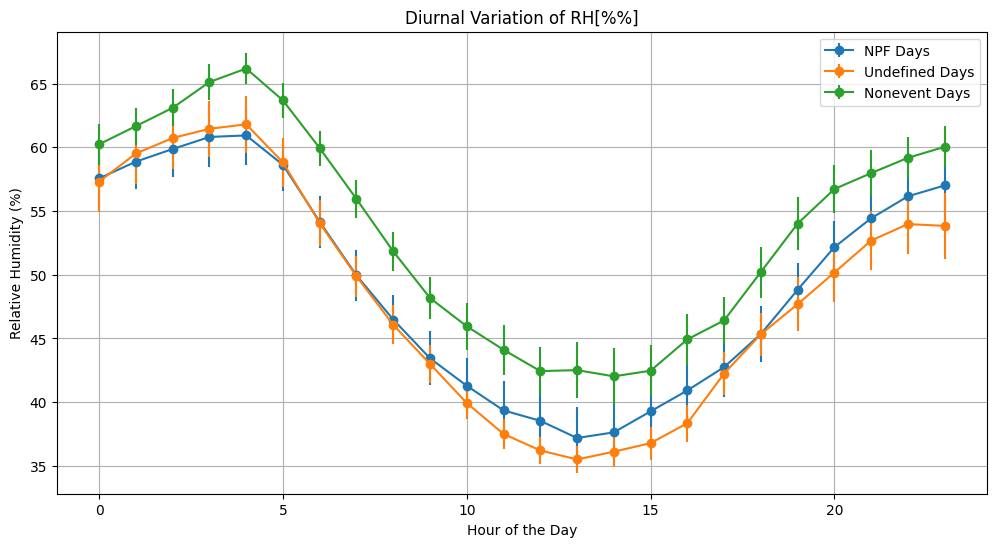

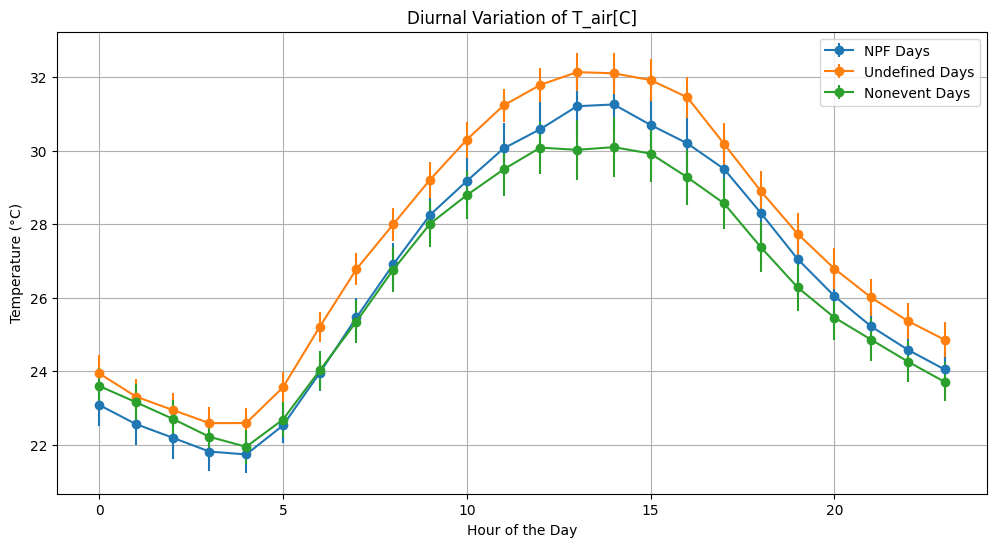

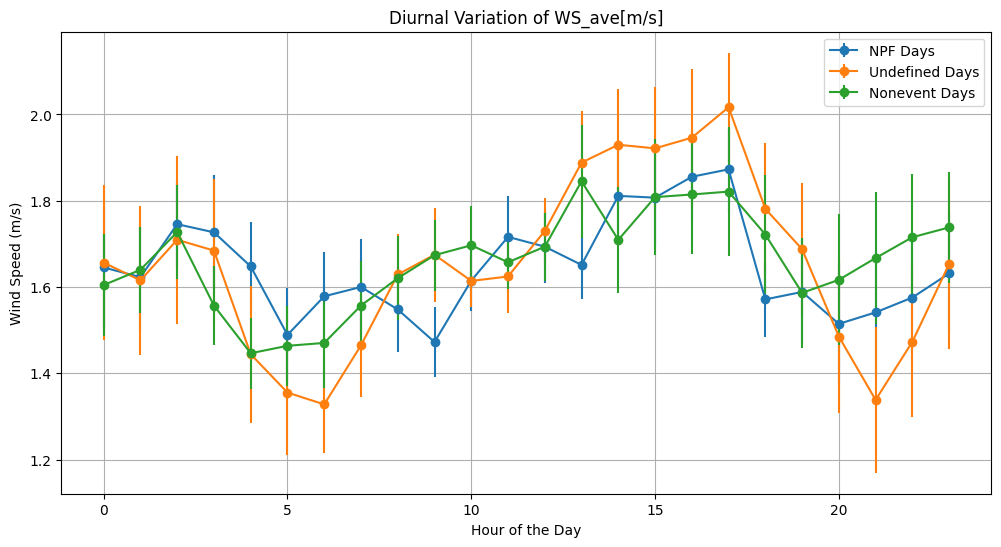

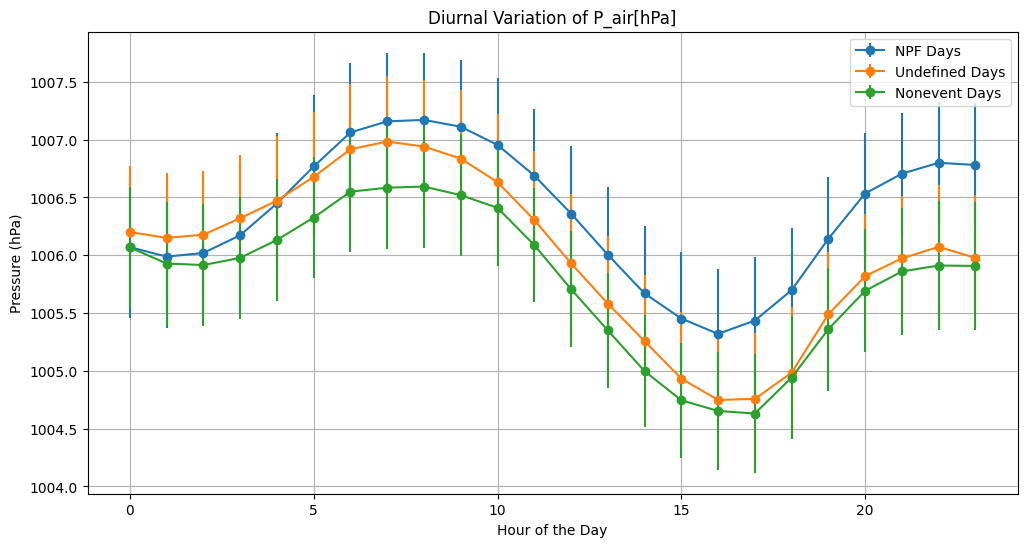

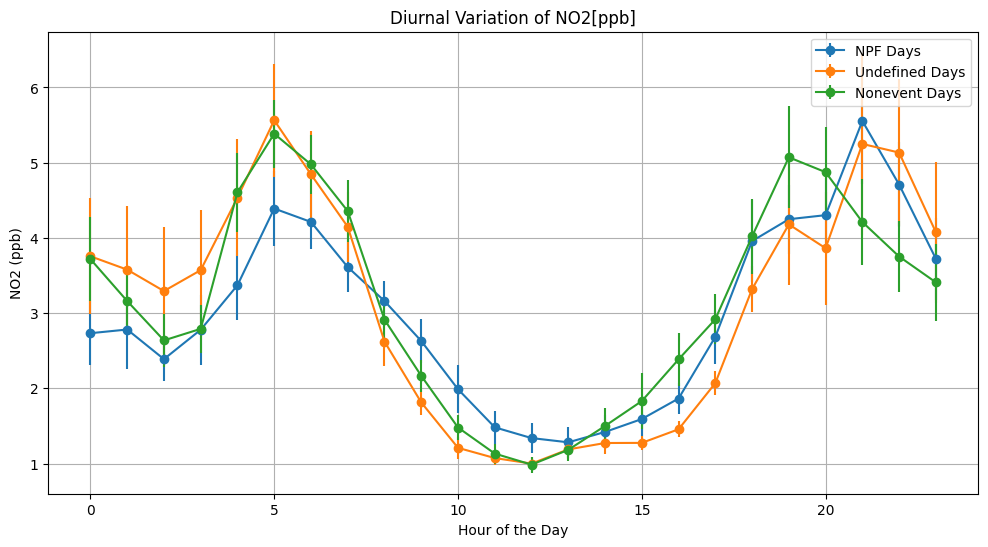

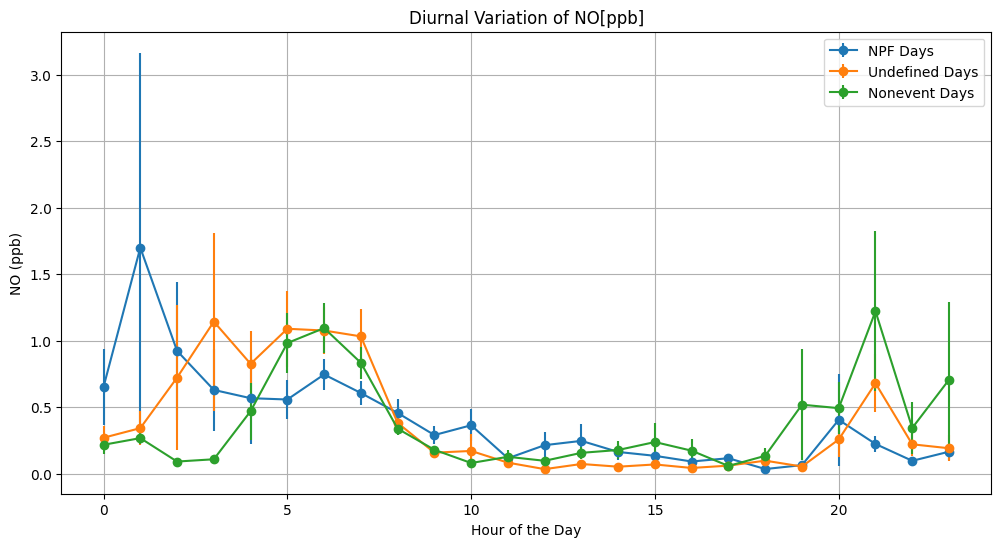

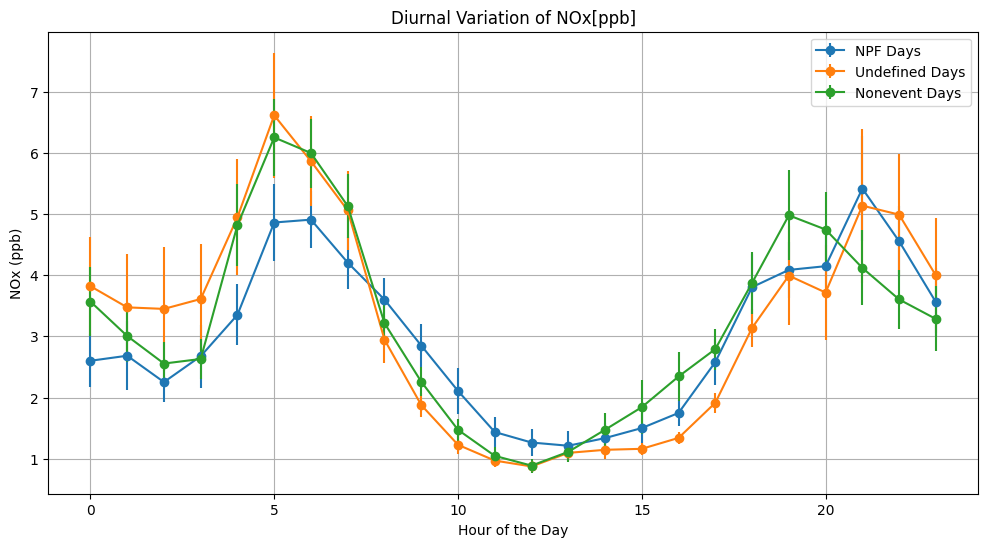

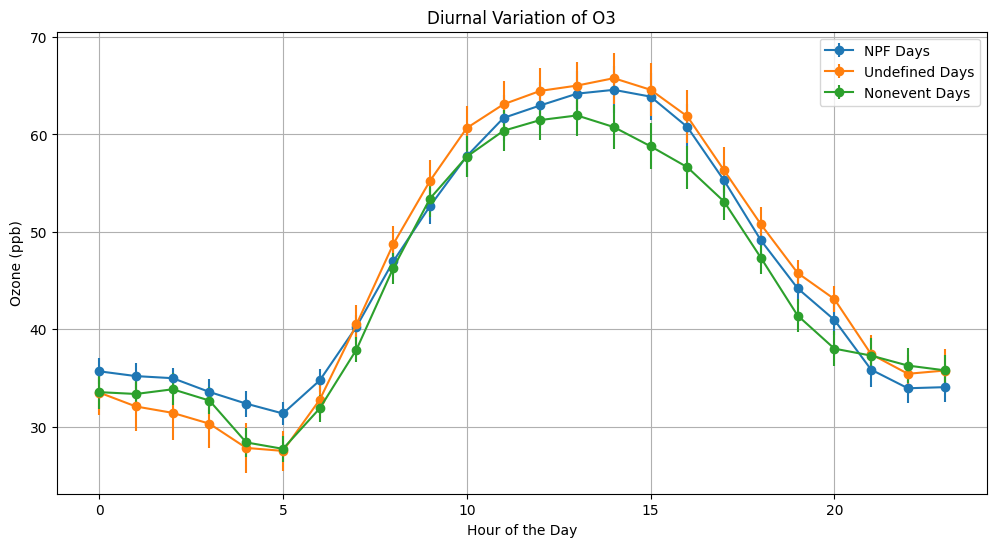

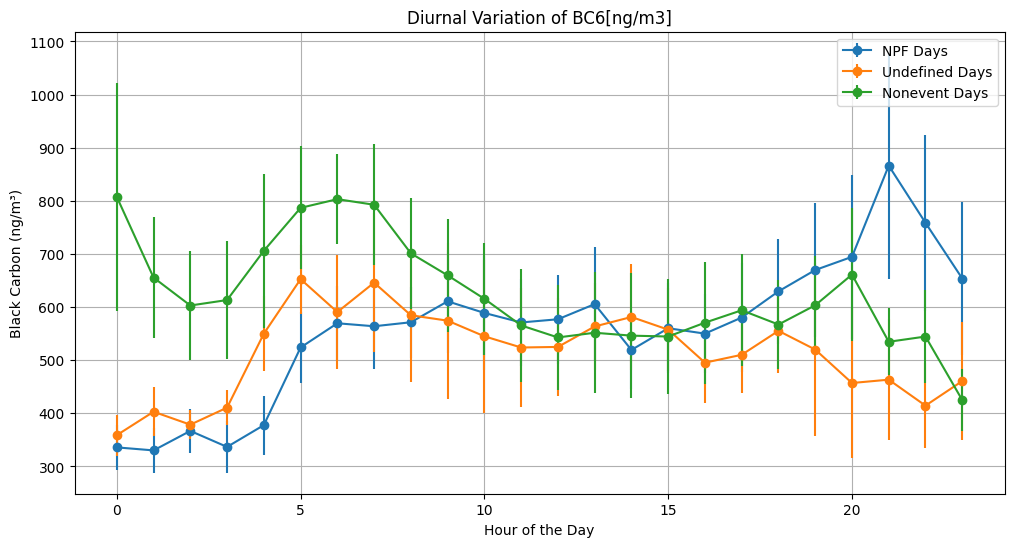

In [48]:
# Function to plot diurnal variation with standard error
def plot_diurnal_variation(variable, ylabel):
    plt.figure(figsize=(12, 6))
    
    # Plot for NPF days
    mean_npf = npf_df.groupby(npf_df.index.hour)[variable].mean()
    sem_npf = npf_df.groupby(npf_df.index.hour)[variable].sem()
    plt.errorbar(mean_npf.index, mean_npf, yerr=sem_npf, label='NPF Days', fmt='-o')
    
    # Plot for undefined days
    mean_undefined = undefined_df.groupby(undefined_df.index.hour)[variable].mean()
    sem_undefined = undefined_df.groupby(undefined_df.index.hour)[variable].sem()
    plt.errorbar(mean_undefined.index, mean_undefined, yerr=sem_undefined, label='Undefined Days', fmt='-o')
    
    # Plot for nonevent days
    mean_nonevent = nonevent_df.groupby(nonevent_df.index.hour)[variable].mean()
    sem_nonevent = nonevent_df.groupby(nonevent_df.index.hour)[variable].sem()
    plt.errorbar(mean_nonevent.index, mean_nonevent, yerr=sem_nonevent, label='Nonevent Days', fmt='-o')
    
    plt.title(f'Diurnal Variation of {variable}')
    plt.xlabel('Hour of the Day')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# List of variables to plot
variables = [
    ('N_small_neg concentration', 'Concentration (cm$^{-3}$)'),
    ('N_small_pos concentration', 'Concentration (cm$^{-3}$)'),
    ('N_intermediate_neg concentration', 'Concentration (cm$^{-3}$)'),
    ('N_intermediate_pos concentration', 'Concentration (cm$^{-3}$)'),
    ('N_large_neg concentration', 'Concentration (cm$^{-3}$)'),
    ('N_large_pos concentration', 'Concentration (cm$^{-3}$)'),
    ('RH[%%]', 'Relative Humidity (%)'),
    ('T_air[C]', 'Temperature (°C)'),
    ('WS_ave[m/s]', 'Wind Speed (m/s)'),
    ('P_air[hPa]', 'Pressure (hPa)'),
    ('NO2[ppb]', 'NO2 (ppb)'),
    ('NO[ppb]', 'NO (ppb)'),
    ('NOx[ppb]', 'NOx (ppb)'),
    ('O3', 'Ozone (ppb)'),
    ('BC6[ng/m3]', 'Black Carbon (ng/m³)')
]

# Plot diurnal variation for each variable
for variable, ylabel in variables:
    plot_diurnal_variation(variable, ylabel)

In [49]:
#Calculate condensation sink, assuming that the condensing gas is sulfuric acid in air with aerosol particles.
af.calc_cs(small_pos_ions_df, temp=293.15, pres=101325.0)

time
2024-06-01 00:00:00    3.757271e-07
2024-06-01 01:00:00    3.510940e-07
2024-06-01 02:00:00    3.165169e-07
2024-06-01 03:00:00    2.939890e-07
2024-06-01 04:00:00    2.722373e-07
                           ...     
2024-08-31 19:00:00    1.639386e-07
2024-08-31 20:00:00    1.651392e-07
2024-08-31 21:00:00    2.126408e-07
2024-08-31 22:00:00    2.554149e-07
2024-08-31 23:00:00    2.917235e-07
Length: 2208, dtype: float64